# Image Caption Generator using LSTM and Bidirectional LSTM

"""
Copyright (c) 2018, by the Authors: Abhinav Tiwari, Ronak Mistry, Shivam Negi
This software is freely available under the MIT Public License. 
Please see the License file in the root for details.
""";

## Importing required libraries

In [52]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

## Data Preprocessing

tqdm - Instantly makes your loops show a smart progress meter which is really useful for monitoring when doing those time consuming encoding and training in deep learning. Check out the package here- https://pypi.org/project/tqdm/4.19.5/

In [2]:
from tqdm import tqdm

Flickr8k.token.txt is the file which has-
(image id - caption number - caption) in that order as can be seen below in variable captions.
Note: Each image has 5 descriptions each which is collected by flickr. The way to download the whole file is in our dependencies file

In [3]:
token = 'Flickr8k_text/Flickr8k.token.txt'


Unzip the downloaded folder as it is and save the  main unzipped "Flickr8k_text" folder in the same directory as your Jupyter notebook so as to run the notebook as is and not having to use absolute path. It has all the annotations, captions and the splits of training, test set in terms of image id in the txt format

In [4]:
captions = open(token, 'r').read().strip().split('\n')
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

The following function is used to enumerate the captions and then remove the caption number from each row. So as to get only the image id.

In [7]:
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
print(row[0])


997722733_0cb5439472.jpg


Using the function above we store each image id. then we store each image id with its corresponding 5 captions in a dictionary as a key-value pair

In [9]:

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
d        

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

Checking the dictionary for a certain key(image id) in the dictionary stored

In [10]:
d['1002674143_1b742ab4b8.jpg']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

The Flicker8k_Dataset has 8000 images in it. It does not have a seperate folder for train and test. But using the train and test txt files we have to make a data split based on the image id given and make seperate set for train and test

In [22]:
images = 'Flicker8k_Dataset/'


The glob module finds all the pathnames matching a specified pattern. In here, we are specifiying the pathname using "images" variable and then importing all the files that have .jpg extension

In [23]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [24]:
img[:5]

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [1]:
from IPython.display import Image

The 'Flickr8k_text/Flickr_8k.trainImages.txt' contains all the image-ids for training set in text format
![alt text](./pics/files4train.png "Title")

In [43]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'


Making a set for the train_images. We use set because set forbids duplicates and we cannot have duplicate image-ids.

In [44]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(train_images)                  

{'512634877_d7ad8c8329.jpg', '2415265825_fbfe0c8556.jpg', '2384147448_c1869070d3.jpg', '2971298546_dd595cf297.jpg', '3250593457_9049a73b61.jpg', '2808870080_4ea4f3327e.jpg', '1685990174_09c4fb7df8.jpg', '3164415865_612f9fd8bc.jpg', '3427023324_f1f6504bf4.jpg', '2872963574_52ab5182cb.jpg', '2911107495_e3cec16a24.jpg', '2618866067_07cbc83dc5.jpg', '3042488474_0d2ec81eb8.jpg', '3339751521_7a8768be27.jpg', '3454315016_f1e30d4676.jpg', '399212516_d68046b277.jpg', '3036596725_541bbe0955.jpg', '2062607137_dac194ad02.jpg', '2514581496_8f4102377e.jpg', '3042381160_ffe2b16808.jpg', '3189293145_35dea42679.jpg', '2068465241_3bcabacfd7.jpg', '3148286846_40ae914172.jpg', '2492258999_5764124bba.jpg', '2884092603_786b53a74b.jpg', '3304030264_da3dd18c7b.jpg', '219843859_94b6d0a580.jpg', '3106782647_b078830a9e.jpg', '3030223792_02b6f2be99.jpg', '398413603_166896900f.jpg', '2194806429_ca4c3770c1.jpg', '3690348036_a01f243fb0.jpg', '501650847_b0beba926c.jpg', '1478294229_7e1c822fea.jpg', '3334057289_68ece3

Making a split data function to split the whole image folder into 6000 train images given in the file above

In [45]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [46]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)


6000

In [47]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))


In [48]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In the same way making a split for the test set(1000 images)

In [49]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [50]:
# Getting the test images from all the images
test_img = split_data(test_images)
len(test_images)

1000

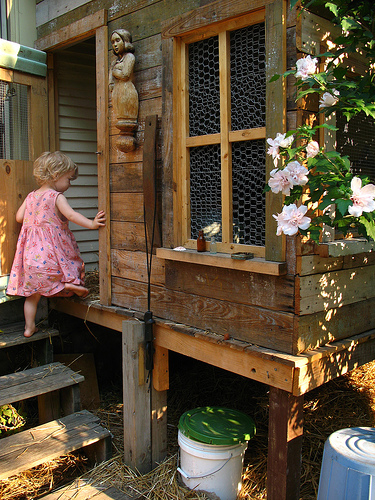

In [53]:
Image.open(train_img[0])

The steps below are for preprocessing of input images which can be found in keras applications documentation. It is very well written and expalined

The preprocess_input function is meant to adequate the images to the format the model requires.
Some models use images with values ranging from 0 to 1. Others from -1 to +1.

In [54]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

Keras works with batches of images. So, the first dimension is used for the number of samples (or images) you have.

When you load a single image, you get the shape of one image, which is (size1,size2,channels). 
NOTE: SINCE WE ARE USING TENSORFLOW AS BACKEND FOR KERAS. Tf IS A CHANNEL_LAST CONFIGURATION

In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels)

Hence the np.expand_dims is used to expand the size to get the whole batch of images

In [64]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


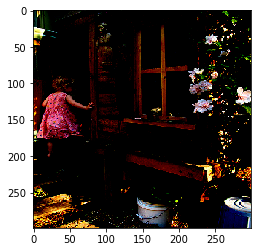

In [56]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

Since we have expanded the dimenstion during data preprocessing phase. which is necessary for pre-processing of batch of images. we now have an extra dimension to deal with 

In [57]:
(preprocess(train_img[0])).shape

(1, 299, 299, 3)

np.squeeze is used to remove single-dimensional entries from the shape of an array. which can be displayed using the "dpk" variable below

In [65]:
np.squeeze(preprocess(train_img[0]))

array([[[-0.54509807, -0.56078434, -0.3960784 ],
        [-0.09803921,  0.02745104,  0.0196079 ],
        [-0.06666666,  0.05098045,  0.09019613],
        ...,
        [-0.9607843 , -0.9607843 , -0.9764706 ],
        [-0.96862745, -0.96862745, -0.9843137 ],
        [-0.9529412 , -0.9529412 , -0.96862745]],

       [[-0.5921569 , -0.6       , -0.4588235 ],
        [-0.09803921,  0.0196079 , -0.03529412],
        [-0.05882353,  0.07450986,  0.13725495],
        ...,
        [-0.96862745, -0.9764706 , -1.        ],
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.9843137 , -0.96862745, -0.9764706 ]],

       [[-0.6156863 , -0.6392157 , -0.47450978],
        [-0.09019607,  0.02745104,  0.00392163],
        [-0.0745098 ,  0.05098045,  0.15294123],
        ...,
        [-0.9137255 , -0.9137255 , -0.92941177],
        [-0.8901961 , -0.7647059 , -0.9764706 ],
        [-0.78039217, -0.6       , -0.9607843 ]],

       ...,

       [[ 0.32549024, -0.5529412 , -0.94509804],
        [ 0

In [66]:
dpk = np.squeeze(preprocess(train_img[0])).shape
dpk

(299, 299, 3)

## Using and Configuring Inception-v3 model for encoding of images

We first download the model from keras and use the weights that were used to train imagenet. The keras application models are well documented to help you use many of its pre-trained model for your use with help of minor tweaking

In [67]:
model = InceptionV3(weights='imagenet')

We will feed the images to InceptionV3 to get the encoded images.
The last layer of InceptionV3 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. 
This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(2048 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 2048)



![title](./pics/image03.png)

In [61]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [62]:
tryi = model_new.predict(preprocess(train_img[10]))


In [63]:
tryi.shape

(1, 2048)

Here we are
1:using the preprocess function to pre-process the image for the size(299x299x3) for Inception-v3
2:Then we are using the above Inception-v3(without the softmax classifier to encode the training and test images to get feature extraction)

In [74]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc


The encoding takes some time but it is faster on the inception model as compared to the vgg-16 model because the number of paramters are less in inception which helps our training time and model size on the whole. Also, the top-1,3,5% errors of both models are near-about same

In [ ]:

#encoding_train = {}
#for img in tqdm(train_img):
#    encoding_train[img[len(images):]] = encode(img)

NOTE: uncomment the code above and below to encode for train images

In [ ]:
#with open("new_encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    #pickle.dump(encoding_train, encoded_pickle)

We have written the encoded images in a pickle file so that we can directly load it from our local machine and not have to wait all over again for the images to encode. Saves time if your kernel dies in between training. Trust us, it happens a lot of times when training a model so huge and big data sets

In [76]:
with open('new_encoded_images_inceptionV3.p', 'rb') as b:
    encoding_train = pickle.load(b)

In [77]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

Here we have used the tqdm package as we explained above. it is really helpful as you can be exactly how much time it will take your loop to work and also shows progress bar!!

In [ ]:
#encoding_test = {}
#for img in tqdm(test_img):
#    encoding_test[img[len(images):]] = encode(img)

NOTE: uncomment the code above and below to encode for test images

In [ ]:
#with open("new_encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    #pickle.dump(encoding_test, encoded_pickle)

We have written the encoded images in a pickle file so that we can directly load it from our local machine and not have to wait all over again for the images to encode. Saves time if your kernel dies in between training. Trust us, it happens a lot of times when training a model so huge and big data sets

In [79]:
with open('new_encoded_images_test_inceptionV3.p', 'rb') as a:
    encoding_test = pickle.load(a)

In [80]:
encoding_test[test_img[0][len(images):]].shape


(2048,)

Create dictionaries for both train and test. The keys are image names and the values are the captions associated with those images.

In [81]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

        

test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

## Calculating unique vocabulary

For word embedding and RNN model it very important to get the number of unique words in your vocabulary for the images to train and then predict outcome using the given set of vocab

In [82]:

caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

Here we are adding start and end words to our vocab so that the model knows it has to start and end the prediction when it sees the words.
NOTE: start will indicate the model that it has to start predicting and end will indicate it to stop

In [37]:

words = [i.split() for i in caps]

Here we have basically tokenized the words in the captions

In [38]:
words = [i.split() for i in caps]
unique = []
for i in words:
    unique.extend(i)

Again here for this we have used a set as we do not want any duplicate vocab and it needs to be unique

In [39]:

unique = list(set(unique))

In [40]:

unique = pickle.load(open('unique.p', 'rb'))

The code above and below are used to save the various vocab in two forms:

1. A pickle file as it convenient and machine-readable, also can be used across platforms

2. A text file so that we humans can read it and be satisfied that the function we used has worked as we wanted it to!!

In [41]:

thefile = open('Inception_vocab.txt', 'w')
for item in unique:
  thefile.write(str(item) + "\n")
thefile.close() 

In [42]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

As it can be seen below that our vocab has 8256 words in it. This is an important paramter for our model and will be used in the model later on

In [43]:
file_len('Inception_vocab.txt')

8256

Mapping unique words to indices

In [44]:


word2idx = {val:index for index, val in enumerate(unique)}

Mapping of words or tokenizing it, is very important as it gives references a word to a number and vice-versa.

It is of importance to our model as our model will be given indices and will also return indices during prediction phase which in turn will be converted to the corresponding word.

In [45]:
word2idx['<start>']


5553

In [46]:
idx2word = {index:val for index, val in enumerate(unique)}

In [47]:
idx2word[5553]

'<start>'

The maximum length of the sequence to generate, needed for padding inputs can be seen during model building phase

In [48]:

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [49]:

vocab_size = len(unique)
vocab_size

8256

In [50]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [51]:
f1 = open('flickr8k_test_dataset.txt', 'w')
f1.write("image_id\tcaptions\n")

for key, val in test_d.items():
    for i in val:
        f1.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f1.close()

df_test=pd.read_csv('flickr8k_test_dataset.txt', delimiter='\t')

The train and test set are converted into df as can be shown below having columns("image_id" , "captions")

Start and end words are added before and after every caption for the model and data generator to understand as to when to initiate and when to terminate (Image below shows a snap of train data id and captions)

![title](./pics/img_cap.png)

In [52]:

for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [53]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')


In [54]:

c = [i for i in df['captions']]
len(c)

30000

In [55]:
imgs = [i for i in df['image_id']]

In [56]:

a = c[10]
a, imgs[10]

('<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
 '1002674143_1b742ab4b8.jpg')

As explained above each word in the model has to be processed using it unique word_id to get mapped 

In [57]:

for i in a.split():
    print (i, "->", word2idx[i])

<start> -> 5553
A -> 4228
little -> 2694
girl -> 2482
covered -> 3168
in -> 8156
paint -> 1276
sits -> 6267
in -> 8156
front -> 522
of -> 3747
a -> 32
painted -> 7130
rainbow -> 6176
with -> 4350
her -> 7258
hands -> 3535
in -> 8156
a -> 32
bowl -> 1970
. -> 7023
<end> -> 5232


Samples_per_epoch is an important parameter as it shows how many times the model has to iterate to complete one epoch.
This represents the captions multiplied by each word in every caption in training(i.e. the number of words that can be found in captions even counting repeated words)

In [58]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1
samples_per_epoch    

383454

# Generator

We will use the encoding of an image and use a start word to predict the next word. After that, we will again use the same image and use the predicted word to predict the next word. So, the image will be used at every iteration for the entire caption. This is how we will generate the caption for an image. Hence, we need to create a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept:https://youtu.be/cO0a0QYmFm8?t=32m25s

![title](./pics/Layers.png)

Image is a part of his lecture

In [59]:

def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1) #frac is used to return fraction of axis items
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Model 1

In [90]:
from keras.layers import Concatenate
from keras.layers import Activation, Dense
from keras.layers import Input, Dropout
from keras.layers import concatenate
from keras.layers import Add
from keras.utils import plot_model


1. The input size for this model is defined as 2048 because that is the vector size of the encoded training images above. They are processed by the dense layer to produce a 256 element representation of the photo. 
2. The embedding layer is for handling text input, followed by RNN(LSTM/BLSTM). The model expects input sequence with a predefined length which is the maximum length of the captions in the training dataset. This is defined as max_len.
3. The embedding size can be set to any value, however, based on trial and error, we found 300 to be an optimal value. The output size here is also 256.
4. The decoder model merges the vector from both the models using the add operation. Variable 'decoder1' is where both the models are added.
5. After the LSTM, the inputs are fed to a final dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

![title](./pics/Schematic-of-the-Merge-Model-For-Image-Captioning.png)

In [91]:

# define the captioning model
def define_model(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256 , return_sequences= True)(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    decoder1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(decoder1)
    se5 = LSTM(256, return_sequences= True)(se4)
    se6 = LSTM(256)(se5)
    decoder2 = Dense(256, activation='relu')(se6)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model

In [ ]:
ultimate_model_2 = define_model(8256,40)

Through trial and error, it was observed that increasing the batch size, the training time and the loss wereboth reduced. However the memory limits on the machine limit us from going beyond 512. Also, a high batch_size means the model does not generalize well.

In [ ]:
batch_size = 512

ultimate_model_2.fit_generator(data_generator(batch_size), samples_per_epoch=(samples_per_epoch/batch_size), epochs=15, 
                          verbose=1)

In [ ]:
ultimate_model_2.save_weights('GPU_model2_exp2_loss.h5')
from keras.models import load_model


ultimate_model_2.save('GPU_ultimate_model.h5')


In [ ]:


model_json = ultimate_model_2.to_json()
with open("GPU_model.json", "w") as json_file:
    json_file.write(model_json)

argmax search is where the max value index(argmax) in the vector of length 8256 is extracted and appended to the result. This is done until we hit a 'end' flag or the max length of the caption.

In [61]:

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = ultimate_model_2.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:

try_image = test_img[22]
Image.open(try_image)

In [ ]:
print ('Normal search:', predict_captions(try_image))

## Model 2

In [ ]:
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input
from keras.layers import Bidirectional , TimeDistributed
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

# define the captioning model
def define_model_2(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = Bidirectional(LSTM(256,return_sequences=True))(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    main1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(main1)
    BLSTM1 = Bidirectional(LSTM(256, return_sequences=True))(se4)
    print(BLSTM1.shape)
    BLSTM2 = Bidirectional(LSTM(256))(BLSTM1)
    decoder2 = Dense(256, activation='relu')(BLSTM2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy',  optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model
    

In [ ]:
trial_model = define_model_2(8256,40)

In [ ]:
#Keras-callbacks
#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=, verbose=1)
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
#mcp = ModelCheckpoint(filepath='BEST_model1_exp1_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

batch_size = 512
trial_model.fit_generator(data_generator(batch_size), steps_per_epoch=(samples_per_epoch/batch_size),epochs=15,verbose=1)

In [ ]:
trial_model.save_weights('GPU_blstm_model1_exp1_loss.h5')
from keras.models import load_model
trial_model_json_model = trial_model.to_json()

trial_model.save('GPU_blstm_trial_model.h5')



In [ ]:
from keras.models import load_model
t_model = load_model('GPU_blstm_trial_model.h5')

In [62]:
def predict_captions_2(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = t_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
try_image = test_img[20]
Image.open(try_image)

## Evaluation

The Flickr-8k dataset after preprocessing, provides data in the form of a dictionary where, the key is an image and the value for that image is a set of 5 captions. The BLEU metric is used to compare the predicted caption from the model to all the given caption labels. The best match from all these labels is picked as the final BLEU score.

In [63]:
#Import BLSTM model from saved file
from keras.models import load_model
t_model = load_model('GPU_blstm_trial_model.h5')

In [66]:
#Import tokenizer from nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhinav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [67]:
#Predict captions for BLSTM
#Returns a dictionary with image and predicted caption
pred_dict = {}
for img in tqdm(test_img):
    pred_sent = predict_captions_2(img)
    pred_dict[img] = word_tokenize(pred_sent)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:15<00:00,  1.22s/it]


In [68]:
#Sentence bleu function to calculate bleu score using tokenized sentences
from nltk.translate.bleu_score import sentence_bleu


In [69]:
#Calculate BLEU for BLSTM
#Compares both dictionaries to give an output bleu score for each image
dict_map_2 = {}
for img in tqdm(pred_dict.keys()):
    predicted_sentence = pred_dict[img]
    sent_list = []
    for sent in test_d[img]:
        sent_list.append(word_tokenize(sent))
    #Check bleu
    #score = sentence_bleu(sent_list, predicted_sentence)
    score = sentence_bleu(sent_list, predicted_sentence, weights=(1, 0, 0, 0))
    dict_map_2[img] = score

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 885.12it/s]


In [70]:
#BLEU score is aggregated
blue_val = 0
for it in dict_map_2.values():
    blue_val = blue_val + it

In [71]:
#Converting to percentage
blue_val / 1000

0.5719663033076788

In [72]:
#Import LSTM model
from keras.models import load_model
ultimate_model_2 = load_model('GPU_ultimate_model.h5')

In [74]:
#Predict captions for each image
pred_dict_2 = {}
for img in tqdm(test_img):
    pred_sent = predict_captions(img)
    pred_dict_2[img] = word_tokenize(pred_sent)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:56<00:00,  1.52it/s]


In [75]:
#Calculate bleu score
dict_map = {}
for img in tqdm(pred_dict_2.keys()):
    predicted_sentence = pred_dict_2[img]
    sent_list = []
    for sent in test_d[img]:
        sent_list.append(word_tokenize(sent))
    #Check bleu
    #score = sentence_bleu(sent_list, predicted_sentence)
    score = sentence_bleu(sent_list, predicted_sentence, weights=(1, 0, 0, 0))
    dict_map[img] = score

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 907.83it/s]


In [76]:
#Aggregate bleu score
bleu_val_2 = 0
for it in dict_map.values():
    bleu_val_2 = bleu_val_2 + it

In [77]:
#Convert to percentage
bleu_val_2 / 1000

0.5764705346734418

The images below show histograms of BLEU evaluations for both the models. They show the distribution of the score values for each sentence in the test dataset. Visibly, most sentences have a 50% or h

C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


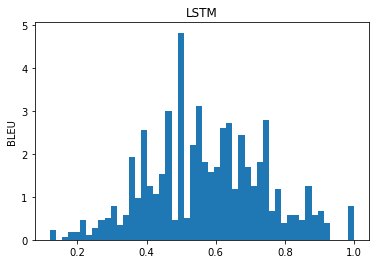

In [78]:
#BLEU histogram for LSTM
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = dict_map.values()
plt.title("LSTM")
plt.hist(x, normed=True, bins=50)
plt.ylabel('BLEU');

C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


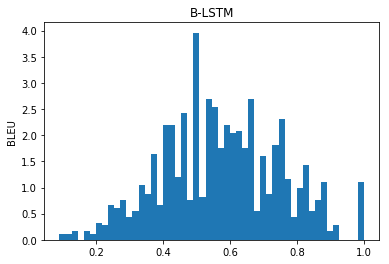

In [79]:
#BLEU histogram for BLSTM
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = dict_map_2.values()
plt.title("B-LSTM")
plt.hist(x, normed=True, bins=50)
plt.ylabel('BLEU');